<p/>
<p style="font-size:70px; font-weight: bolder; text-align: center; margin-bottom: 20px;"> Constant-pressure (PI)MD </p>
<p style="font-size:30px; text-align: center; line-height: 1.5;"><i> authored by:  Hannah Bertschi, Jorge Castro, George Trenins </i>
<br/>
<i> adapted from <a href="https://github.com/i-pi/piqm2023-tutorial" target="_blank">tutorials for the PIQM-2023 Advanced School</a></i></p>

In this tutorial we explore molecular dynamics simulations at constant temperature and pressure. Using the [i-PI package](https://ipi-code.org) we will perform classical molecular dynamics (MD) and path-integral molecular dynamics (PIMD) simulations of low-temperature, high-pressure solid hydrogen. By the end, you will learn to set up thermostats and barostats in i-PI, how to restart simulations from checkpoint files, and how to visualize the output data using [chemiscope](https://atomistic-cookbook.org/software/chemiscope.html). You will also see the substantial impact of *thermal quantum swelling* on the equilibrium density of solid hydrogen.

<p/>
<p style="font-size:60px; font-weight: bolder; text-align: center; margin-bottom: 20px;"> Simulation cell  </p>
<center><img src="images/pbc.svg" alt="3-by-3 tiling of a 2D supercell" style="height:70vh;"></center>
</p>

In [1]:
# Load and display the initial supercell
from ase.io import read
import chemiscope
structure = read('classical/para-h2.pdb')
chemiscope.show(
    frames=[structure], mode="structure",
    settings=chemiscope.quick_settings(
        structure_settings={"atoms": True, "spaceFilling": True, "unitCell": True}))

<StructureWidget(meta={'name': ' '}, settings={'map': {'joinPoints': False}, 'structure': [{'keepOrientation':…

<p>
    <p style="font-size:60px; font-weight: bolder; text-align: center; margin-bottom: 70px;"> 
        Temperature and pressure control  
    </p>
    <p class="fragment" style="margin-bottom: 40px;">
        $$
        \mathcal{P}_\mathrm{NPT}(\mathbf{q},\mathbf{p}, V)\propto \mathrm{e}^{-\beta[E(\mathbf{q}, \mathbf{p})+P_\mathrm{ext}V]}
        $$
    </p>
    <p class="fragment" style="text-align: center; margin-bottom: 25px">
        sampled by
    <p/>
    <p class="fragment">
        $$
        \begin{align*}
        \dot{p} & = -\partial U/\partial q \color{blue}{-\alpha p/\mu} \color{red}{-\gamma_p p + b_p \xi(t)} &
        \dot{q} & = \frac{p}{m} \color{blue}{+\alpha q/\mu}\\
        \end{align*}
        $$
    </p>
    <p class="fragment">
         $$
        \begin{align*}
        \dot{\alpha} & = \color{blue}{3\left[V\left(P_\mathrm{int}-P_\mathrm{ext}\right)+2k_{B}T\right]} \color{red}{- \gamma_\alpha \alpha + b_\alpha \chi(t)} &
        \dot{V} & = \color{blue}{3V\alpha/\mu}
        \end{align*}
        $$
    </p>
</p>

<p>
    <p style="font-size:60px; font-weight: bolder; text-align: center; margin-bottom: 50px;"> 
        Pressure control with a barostat  
    </p>
    <p class="fragment">
        $$
        \begin{align*}
        \dot{p} & = -\partial U/\partial q \color{blue}{-\alpha p/\mu} &
        \dot{q} & = \frac{p}{m} \color{blue}{+\alpha q/\mu}\\
        \dot{\alpha} & = \color{blue}{3\left[V\left(P_\mathrm{int}-P_\mathrm{ext}\right)+2k_{B}T\right]} &
        \dot{V} & = \color{blue}{3V\alpha/\mu}
        \end{align*}
        $$
    </p>
    <br/>
    <div style="display: flex; justify-content: space-between;">
        <div style="width: 48%;">
            <ul>
                <li class="fragment">$\rule[-0.25em]{0pt}{1.5em}%
                    \text{cell volume }V\text{ is a dynamical variable}$</li>
                <li class="fragment">$\rule[-0.25em]{0pt}{1.5em}%
                    V \text{ associated with mass } \mu \text{ and momentum } \alpha $</li>
                <li class="fragment">$\rule[-0.25em]{0pt}{1.5em}%
                    \alpha / \mu\text{ is its scaling rate}$</li>
                <li class="fragment">$\rule[-0.25em]{0pt}{1.5em}%
                    q\text{ scales at the same rate}$</li>
                <li class="fragment">$\rule[-0.25em]{0pt}{1.5em}%
                    \mathrm{d}q_{t} \mathrm{d}p_{t} = \mathrm{d}q_{0} \mathrm{d}p_{0}$</li>
            </ul>
        </div>
        <div style="width: 48%;">
            <center>
                <img src="images/NPH.svg" alt="simulation cell under extrenal pressure from an isotropic piston" style="width: 100%; " class="fragment">
            </center>
        </div>
    </div>
</p>

<p>
    <p style="font-size:60px; font-weight: bolder; text-align: center; margin-bottom: 50px;"> 
        Temperature control with a thermostat 
    </p>
    <p>
        \begin{align*}
        \dot{p} & = -\partial U/\partial q \color{blue}{-\alpha p/\mu} \color{red}{-\gamma_p p + b_p \xi(t)} &
        \dot{q} & = \frac{p}{m} \color{blue}{+\alpha q/\mu} \\
        \dot{\alpha} & = \color{blue}{3\left[V\left(P_\mathrm{int}-P_\mathrm{ext}\right)+2k_{B}T\right]} \color{red}{- \gamma_\alpha \alpha + b_\alpha \chi(t)} &
        \dot{V} & = \color{blue}{3V\alpha/\mu}
        \end{align*}
    </p>
    <p> 
      <ul>
        <li class="fragment">$\rule[-0.25em]{0pt}{1.5em}
            \mathbf{black} + \color{blue}{\mathbf{blue}}\text{ samples isoenthalpic-isobaric ensemble}$
        </li>
        <li class="fragment">$\rule[-0.25em]{0pt}{1.5em}%
            \text{attaching } \mathbf{\color{red}{thermostats}} \text{ to particles and piston "upgrades" to NPT}$
        </li>
        <li class="fragment">$\rule[-0.25em]{0pt}{1.5em}%
            \mathbf{black} + \color{red}{\mathbf{red}}\text{ samples canonical NVT ensemble}$
        </li>
      </ul>
    </p>

</p>

<p>
    <center>
        <img src="images/NPT.svg" alt="combination of thermostat and barostat" style="width: 1600px; ">
    </center>
    <br/>
    <p>
        \begin{align*}
        \dot{p} & = -\partial U/\partial q \color{blue}{-\alpha p/\mu} \color{red}{-\gamma_p p + b_p \xi(t)} &
        \dot{\alpha} & = \color{blue}{3\left[V\left(P_\mathrm{int}-P_\mathrm{ext}\right)+2k_{B}T\right]} \color{red}{- \gamma_\alpha \alpha + b_\alpha \chi(t)} 
        \end{align*}
    </p>
    <p>
        <ul>
            <li class="fragment">$\rule[-0.25em]{0pt}{1.5em}%
                \text{Two independent thermostats: control momentum fluctuations of particles and of cell volume}
                $</li>
            <li class="fragment">$\rule[-0.25em]{0pt}{1.5em}%
                \text{Langevin thermostat contains friction term with coefficient }\gamma = 1/\tau
                $</li>
            <li class="fragment">$\rule[-0.25em]{0pt}{1.5em}%
                \text{second term is random force through Gaussian random variable } \xi(t), \chi(t)  $</li>
            <li class="fragment">$\rule[-0.25em]{0pt}{1.5em}%
                \text{To impose a temperature }T,\text{ these are scaled by }b = \sqrt{2 \gamma k_{\text{B}} T}
                $</li>
        </ul>
    </p> 
</p>

# Setting up an NPT calculation

We will use the para-hydrogen potential from [I. Silvera and V. Goldman, J. Chem. Phys., 69, 4209 (1978)](https://doi.org/10.1063/1.437103) implemented in i-PI's FORTRAN driver. The simulations is performed at 33 K, where substantial nuclear quantum effects are expected. To verify that this is indeed the case, we begin by running a purely classical (MD) simulation. 

## Input file

Inputs to run molecular dynamics in the constant-pressure ensemble can be found in the `classical` folder. You will find a `para-h2.pdb` file that contains the starting positions of the atoms, and `npt-md.xml`, the actual i-PI input. Let's have a look at them.

### Property output       


<br/>
<div style="max-height: 800px; overflow: auto; border: 1px solid #ccc; padding: 10px; background: #f9f9f9;">

```xml
<simulation verbosity='medium'>
  <output prefix='ph2-npt-md'>
    <properties filename='md' stride='10'>
        [step, time{picosecond}, conserved{electronvolt}, 
         temperature{kelvin}, potential{electronvolt}, kinetic_md{electronvolt}, 
         pressure_md{megapascal}, volume{angstrom3}] 
    </properties>
    <trajectory filename='pos' stride='100' format='pdb' cell_units='angstrom'> 
        positions{angstrom} 
    </trajectory>
    <checkpoint filename='checkpoint' stride='1000' overwrite='True'/>
  </output>
  <total_steps> 10000 </total_steps>
    ...
</simulation>
```

</div>

Next comes the definition of the forcefield. i-PI is designed to propagate nuclear coordinates, while an external program evaluates the forces that drive the dynamics. As a bare minimum, i-PI must communicate the changing nuclear positions to the external program, and the program must in return communicate the corresponding energy and forces. This [communication](https://docs.ipi-code.org/distributed.html#communication-protocol) is realised via sockets, which come in two types: UNIX and TCP/IP. Today we will be using the faster but less versatile UNIX socket,

### Forcefield

```xml
<simulation verbosity='medium'>
    ...
    <ffsocket mode='unix' name='ph2-ff'>
        <address> ph2-driver</address>
    </ffsocket>
    ...
</simulation>
```

The `<address>` tag specifies the socket name, while the `name` attribute specifies how this forcefield is referred to in the `<system><forces>...</forces></system>` section of the input file (see below).

The `<system>` tag defines everything that is system-related. `<initialize>` specifies where to fetch the initial atomic positions and cell size, while `<velocities>` instructs i-PI on how to initialize the particle momenta. We have to specify that the temperature is in Kelvin, otherwise i-PI assumes that it is provided in atomic units.

### System

```xml
<simulation verbosity='medium'>
    ...
    <system>
        <initialize nbeads='1'>
            <file mode='pdb'> para-h2.pdb </file>
            <velocities mode='thermal' units='kelvin'> 33 </velocities>
        </initialize>
        <forces>
            <force forcefield='ph2-ff'/>
        </forces>
        <ensemble>
            <temperature units='kelvin'> 33 </temperature>
            <pressure units='megapascal'> 50 </pressure>
        </ensemble>
        ...
    </system>    
</simulation>
```


`<forces>` specifies how to construct interactions. In this case, we simply fetch them from the single forcefield we defined above, but we shall see how more complicated setups can be realized. 
Finally, `<ensemble>` defines the parameters of the distribution sampled by the dynamics: in this case, a temperature of 33 K and pressure of 50 MPa. 

The way the position of the atoms should be evolved is specified in the `<motion>` section. In this case, we run molecular dynamics in the `npt` ensemble, which means that in addition to the integration `timestep`, we need to specify a `<thermostat>` and a `<barostat>`. The first `thermostat` keyword controls the thermostat acting on the momenta $p$ of the atoms. This is followed by a barostat section, which has its own thermostat controlling the fictitious cell momentum $\alpha$.

### Dynamics


```xml
<simulation verbosity='medium'>
    ...
    <system>
        ...
        <motion mode='dynamics'>
            <dynamics mode='npt'>
                <timestep units='femtosecond'> 1 </timestep>
                <thermostat mode='pile_g'>
                    <tau units='femtosecond'> 25 </tau>
                </thermostat>
                <barostat mode='isotropic'>
                    <tau units='femtosecond'> 250 </tau>
                    <thermostat mode='langevin'>
                        <tau units='femtosecond'> 50 </tau>
                    </thermostat>
                </barostat>
            </dynamics>
        </motion>
    </system>
</simulation>
```

- `tau` keyword gives time scale of the relaxation

## Running the simulation

To run the calculation, starting from the root directory perform the following:

- change to directory containing the i-pi inputs for the classical simulation
```bash
cd 01-constant-pressure/classical
```
- execute `./run_md.sh`

- monitor progress of the simulation via
```bash
tail -f log.md
```
- press <kbd>Ctrl</kbd> + <kbd>C</kbd> to stop "tailing"

## Visualizing and analyzing results

We use some utility functions to read the output of i-PI and visualize it. Note the fast equilibration of the cell volume, and how the pressure estimator converges to the target value. 

In [5]:
%%capture cap
from ipitools.io_ipi import read_ipi_output
import matplotlib.pyplot as plt
from pathlib import Path
datadir = Path("classical")  # change to "output" to load reference data
md_output = read_ipi_output(datadir/'ph2-npt-md.md')
fig, ax = plt.subplots(1,3,figsize=(12,3),sharex=True)
# Simulation cell volume
ax[0].plot(md_output["time"], md_output["volume"], 'C0-', label="volume")
ax[0].set_xlabel("t / ps")
ax[0].set_ylabel("V / Å$^3$")
ax[0].legend()
# Internal and external pressure
ax[1].plot(md_output["time"], md_output["pressure_md"], 'C1-', label=r'$P_\text{int}$')
ax[1].axhline(y=50, color='k', label=r'$P_\text{ext}$')
ax[1].set_xlabel("t / ps")
ax[1].set_ylabel(r"P / MPa")
ax[1].legend()
# (Kinetic) temperature
ax[2].plot(md_output["time"], md_output["temperature"], 'C2-', label=r'$T_\text{sys}$')
ax[2].axhline(y=33, color='k', label=r'$T_\text{bath}$')
ax[2].set_xlabel("t / ps")
ax[2].set_ylabel(r"$T$ / K");
ax[2].set_ylim([0, 50])
ax[2].legend(loc=4)
# Plot the first 2 ps of the dynamics; equilibration is very fast
ax[2].set_xlim([0,2])
plt.tight_layout()
plt.show()

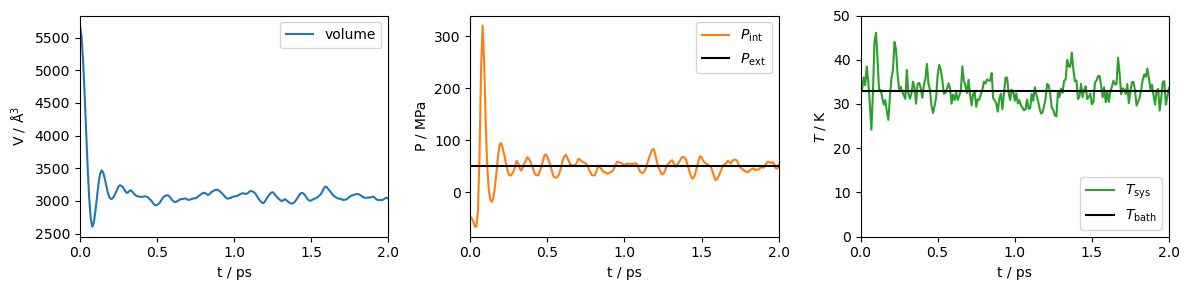

In [4]:
cap.show()

- internal pressure relaxes towards external pressure of 50 MPa
- timescale of equilibration about 250 fs = $\tau$
- temperature fluctuates around bath temperature of 33 K

The internal pressure $P_\text{int}$ equilibrates towards the specified external pressure of 50 MPa within about 250 fs, which is the specified time constant $\tau$ of the barostat. We can also use `chemiscope` to visualize the trajectory. Notice the rapid equilibration of the supercell. 

## Visualizing and analyzing results

In [6]:
%%capture cap
## loads structures, discarding unused atom properties
import warnings
warnings.filterwarnings('ignore', '.*residuenumbers array.*')
frames = read(datadir/'ph2-npt-md.pos_0.pdb', ":")
for f in frames:
    f.info = {}
    f.arrays = {'positions': f.positions,  'numbers': f.numbers}
# Particle coordinates are printed every 100 steps, potential energy and volume -- every 10.
# To match PDB frames to numerical data, use every 10th data point.
stride=10
chemiscope.show(frames=frames, 
                     properties={
                         "t" : { "values":  md_output["time"][::stride], "units": "ps", "target":"structure"},
                         "U" : { "values":  md_output["potential"][::stride], "units": "eV", "target":"structure"},
                         "V" : { "values":  md_output["volume"][::stride], "units": r"Å", "target":"structure"}
                     },
                     settings = {
                         'structure': [{ 'keepOrientation': True, 
                                         'unitCell': True,
                                         "spaceFilling": False,
                                         'playbackDelay': 20}],
                        'map': {'x': {'max': 10,  'min': -0.1, 'property': 't', 'scale': 'linear'},
                                'y': {'max': 5800,  'min': 2500, 'property': 'V', 'scale': 'linear'},
                                 'color': {'property': 'U'}
                               }})

In [7]:
cap.show()

<ChemiscopeWidget(meta={'name': ' '}, settings={'structure': [{'keepOrientation': True, 'unitCell': True, 'spa…

# Constant-pressure path integrals

Systems such as para-hydrogen at cryogenic temperatures exhibit large quantum effects, which affect their thermodynamic properties, and in particular their equations of state. Performing NPT simulation with quantum nuclei in i-PI is really simple: the supercell volume is not quantized, and thus $\alpha$ and $V$ are treated with the same equations of motion as shown above. Every atom is replaced by a ring polymer; the internal pressure is calculated as before, except all classical quantities are replaced by the momenta, positions and forces of the corresponding *ring-poymer centroids*. The centroids are propagated according to equations of motion that are exactly analogous to the classical case. 

- para-hydrogen at cryogenic temperature exhibits large quantum effects
- NPT simulation with quantum nuclei in i-PI:
    - replace every atom by a ring polymer
    - cell volume not quantized

<figure style="text-align: center;">
   <center>
  <img src="images/rp.svg" alt="A simulation cell under extrenal pressure from an isotropic piston" style="width:1000px;">
    </center>
</figure>

The ring-polymer *fluctuation modes* are only coupled to their own thermostats: there is no direct coupling to a barostat.
You can read more about the theory and the implementation in the paper that accompanied the first release of i-PI [[M. Ceriotti, J. More, and D. E. Manolopoulos, Comp. Phys. Comm. 185(3), 1019–1026 (2014)](https://doi.org/10.1016/j.cpc.2013.10.027)].

- centroids propagated according to same equation of motion as classical case
- fluctuation modes only coupled to thermostats

## Input file

- use input file of classical simulation for PIMD
```bash
cd 01-constant-pressure
cp classical/npt-md.xml pimd/npt-pimd.xml
```

- use state of system at end of classical simulation as starting point for PIMD
```bash
cp classical/RESTART pimd/classical-RESTART
cd pimd
```

- input file for PIMD `npt-pimd.xml` needs to be changed

- modify the highlighted parts of the `output` block
<pre><code>
&lt;output <span style="background-color: yellow;">prefix='ph2-npt-pimd'</span>&gt;
  &lt;properties filename='md' stride='10'&gt; 
    [step, time{picosecond}, conserved{electronvolt}, 
     temperature{kelvin}, potential{electronvolt}, kinetic_md{electronvolt}, 
     <span style="background-color: yellow;">kinetic_cv{electronvolt}, pressure_cv{megapascal}</span>, volume{angstrom3}] 
  &lt;/properties&gt;
  &lt;trajectory filename='pos' stride='100' format='pdb' cell_units='angstrom'&gt; positions{angstrom} &lt;/trajectory&gt;
  &lt;checkpoint filename='checkpoint' stride='1000' overwrite='True'/&gt;
&lt;/output&gt;
</code></pre>

- change the socket address
<pre><code>
&lt;ffsocket mode='unix' name='ph2-ff'&gt;
    &lt;address&gt; ph2-driver<span style="background-color: yellow;">-pi</span> &lt;/address&gt;
&lt;/ffsocket&gt;
</code></pre>

- initialize from classical endpoint and use multiple beads

<pre><code>
&lt;initialize nbeads=<span style="background-color: yellow;">'4'</span>&gt;
    &lt;file mode=<span style="background-color: yellow;">'chk'</span>&gt; <span style="background-color: yellow;">classical-RESTART</span> &lt;/file&gt;
&lt;/initialize&gt;
</code></pre>

## Running the simulation

- in `01-constant-pressure/pimd` directory execute `./run_pimd.sh` to start the simulation
- track progress with `tail -f log.pimd`
- press <kbd>Ctrl</kbd> + <kbd>C</kbd> to stop "tailing"

Launch the calculation by executing `./run_pimd.sh`. As before, you can track its progress via `tail -f log.pimd`.

## Post-processing

- The bead number  $N$ is a **parameter** that needs to be converged
- its value depends on the temperature, the particle mass, the PES, and the calculated property

- A good rule of thumb for the highest harmonic frequency of your system is
  $$
 \beta \hbar \omega / N \sim 1
  $$

- in the `outputs` directory we provide results of calculations with 8, 16 and 32 beads

In [8]:
# Load PIMD result into dictionary with numbers of beads as keys
pimd = dict()
datadir = Path("pimd")  # change to "output" to load reference data
pimd[4] = read_ipi_output(datadir/'ph2-npt-pimd.md')
for nbeads in [8, 16, 32]:
    pimd[nbeads] = read_ipi_output(f'output/nbeads{nbeads:02d}/ph2-npt-pimd.md')

### Volume and pressure

In [9]:
%%capture cap
fig, ax = plt.subplots(1,2,constrained_layout=True, figsize=(8,3))
# Plot the cell volume
ax[0].plot(md_output["time"], md_output["volume"], 'b-', label="MD")
colours = ['r', 'g', 'gold', 'grey']
for nbeads, c in zip(sorted(pimd.keys()), colours):
    ax[0].plot(pimd[nbeads]["time"], pimd[nbeads]["volume"], c, label=rf"$N = {nbeads}$")
ax[0].set_ylim([2850, 4250])
ax[0].set_xlabel("t / ps")
ax[0].set_ylabel("V / Å$^3$")
# Plot the internal pressure and add a "shared" legend
lines = []
line, = ax[1].plot(md_output["time"], md_output["pressure_md"], 'b-', label="MD")
lines.append(line)
for nbeads, c in zip(sorted(pimd.keys()), colours):
    line, = ax[1].plot(pimd[nbeads]["time"], pimd[nbeads]["pressure_cv"], c, label=rf"$N = {nbeads}$")
    lines.append(line)
line = ax[1].axhline(50, color='k', label=r'$P_\text{ext}$')
lines.append(line)
fig.legend(handles=lines, ncols=len(lines), loc='lower center', bbox_to_anchor=(0.55, 1.0))
ax[1].set_ylim([0, 100])
ax[1].set_xlabel("t / ps")
ax[1].set_ylabel("p / MPa")
plt.show()

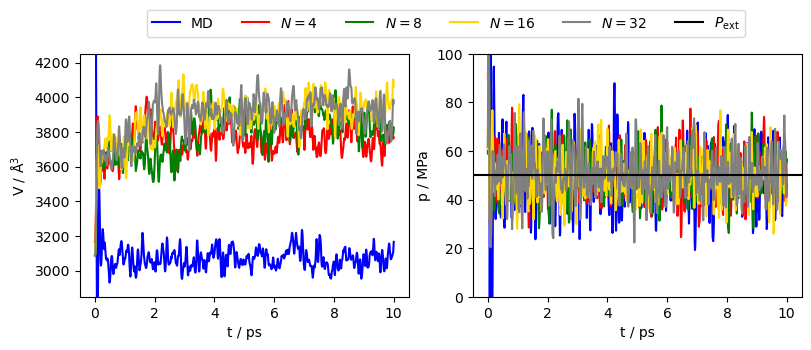

In [11]:
cap.show()

Pressure equilibrates rapidly to the target value of 50 MPa, but the equilibrium volume is much larger than that from the classical simulation, because of zero-point energy effects. At only 4 beads the volume is not quite converged, at least 8 beads are needed.

### Internal energy

- classical MD: the internal energy is the (thermal average) of the sum of potential and kinetic energies
- PIMD: sum the *estimators* for the potential and kinetic energy *operators* 
- potential-energy estimator

$$
U_N = \frac{1}{N}\sum_{j=1}^{N} U(\mathbf{q}^{(j)})
$$

- kinetic energy is trickier
- bead-averaged kinetic energy (`kinetic_md`) is **not** the correct estimator (**except** for the case of $N = 1$) 

- virial estimator (`kinetic_cv`)

In [12]:
%%capture cap
import numpy as np
fig, axarr = plt.subplots(2,2,figsize=(8,6))
ax = np.ravel(axarr)
# Potential energy
ax[0].plot(md_output["time"], md_output["potential"], 'b-', label="MD")
for nbeads, c in zip(sorted(pimd.keys()), colours):
    ax[0].plot(pimd[nbeads]["time"], pimd[nbeads]["potential"], c, label=rf"$N = {nbeads}$")
ax[0].set_xlabel("t / ps")
ax[0].set_ylabel("U / eV")
line, = ax[1].plot(md_output["time"], md_output["kinetic_md"], 'b-', label="MD")
lines = [line]
# Kinetic energy (virial)
for nbeads, c in zip(sorted(pimd.keys()), colours):
    line, = ax[1].plot(pimd[nbeads]["time"], pimd[nbeads]["kinetic_cv"], c, label=rf"$N = {nbeads}$")
    lines.append(line)
ax[1].set_xlabel("t / ps")
ax[1].set_ylabel(r"$K_{\text{cv}}$ / eV");
fig.legend(handles=lines, ncols=len(lines), loc='lower center', bbox_to_anchor=(0.55, 1.0));
# Internal energy (sum of the above)
ax[2].plot(md_output["time"], md_output["kinetic_md"] + md_output["potential"], 'b-', label="MD")
for nbeads, c in zip(sorted(pimd.keys()), colours):
    ax[2].plot(pimd[nbeads]["time"], pimd[nbeads]["kinetic_cv"] + pimd[nbeads]["potential"], c, label=rf"$N = {nbeads}$")
ax[2].set_xlabel("t / ps")
ax[2].set_ylabel(r"$E$ / eV");
# Kinetic energy (the wrong one)
ax[3].plot(md_output["time"], md_output["kinetic_md"], 'b-', label="MD")
for nbeads, c in zip(sorted(pimd.keys()), colours):
    line, = ax[3].plot(pimd[nbeads]["time"], pimd[nbeads]["kinetic_md"], c, label=rf"$N = {nbeads}$")
ax[3].set_xlabel("t / ps")
ax[3].set_ylabel(r"$K_{\text{md}}$ / eV")
fig.tight_layout()
plt.show()

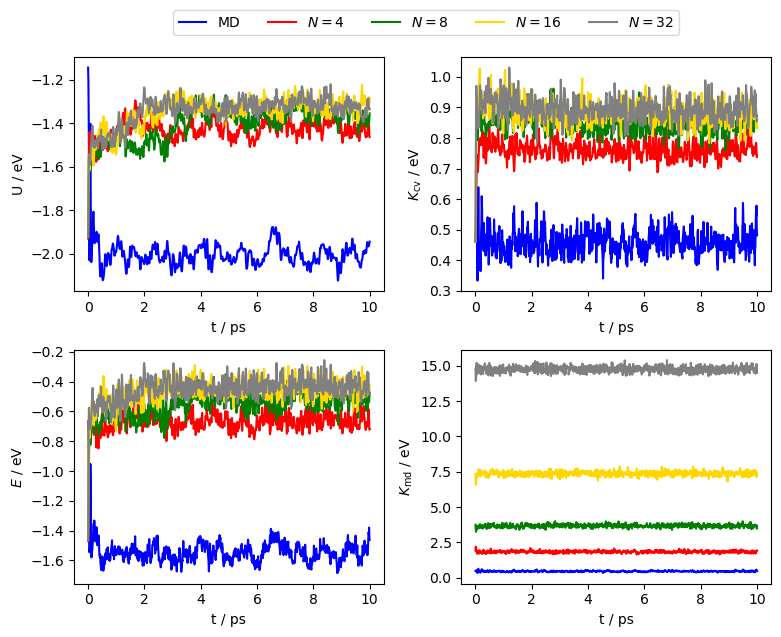

In [14]:
cap.show()

The internal energy converges for $N = 16$, and its mean is substantially larger than in the classical simulation. The difference (about 10 meV per molecule) is a combination of zero-point energy effects and changes due to the expanded cell volume.

### Trajectory visualization

We can also display the ring-polymer trajectories, visualizing the "quantum swelling" of the hydrogen molecules.

In [15]:
%%capture cap
# loads structures, on for every bead
warnings.filterwarnings('ignore', '.*residuenumbers array.*')
pi_frames = [ read(datadir/f'ph2-npt-pimd.pos_{i}.pdb', ":") for i in range(4) ]
frames = []
# At every time-step, join the structures from different bead indices into a single frame
for idx_f in range(len(pi_frames[0])):
    f = pi_frames[0][idx_f]
    for k in range(1,4):
        f += pi_frames[k][idx_f]
    f.wrap()
    f.info = {}
    f.arrays = {'positions': f.positions,  'numbers': f.numbers}
    frames.append(f)
    
chemiscope.show(frames=frames, 
                     properties={
                         "t" : { "values":  pimd[4]["time"][::10], "units": "ps", "target":"structure"},
                         "U" : { "values":  pimd[4]["potential"][::10], "units": "eV", "target":"structure"},
                         "V" : { "values":  pimd[4]["volume"][::10], "units": r"Å", "target":"structure"}
                     },
                     settings = {
                         'structure': [{ 'bonds': False, 
                                         'keepOrientation': True, 
                                         'unitCell': True,
                                         'playbackDelay': 20}],
                        'map': {'x': {'max': 10,  'min': -0.25, 'property': 't', 'scale': 'linear'},
                                'y': {'max': 4000,  'min': 3000, 'property': 'V', 'scale': 'linear'},
                                 'color': {'property': 'U'}
                               }
                     })

In [16]:
cap.show()

<ChemiscopeWidget(meta={'name': ' '}, settings={'structure': [{'bonds': False, 'keepOrientation': True, 'unitC…

- zero point energy swelling due to delocalized quantum nuclei
- liquid at end of simulation, matches experimental phase

### Density calculation

In [17]:
%%capture cap
from ipi.utils import units
from matplotlib import cm
pimd[1] = md_output # for convenience
nmols = len(frames[0]) // 4  # number of molecules = total number of particles in a frame divided by number of beads
m_tot = units.Elements.mass("H")*2 * nmols # mass of all H2 molecules in atomic units
nbeads = [1, 4, 8, 16, 32]
volumes = []
cutoff = 5 # equilbaration time in ps - safe choice for all our trajectories
for N in nbeads:
    mask = pimd[N]["time"] > cutoff
    volumes.append(np.mean(pimd[N]["volume"][mask]))
# mass is in internal (atomic) units - convert volume from AA^3 to internal units as well
volumes = units.unit_to_internal("volume", "angstrom3", np.asarray(volumes))
# density, converted from internal units
densities = units.unit_to_user("density", "g/cm3", m_tot / volumes)
densities *= 1000 # g/cm3 -> kg/m^3
# visualize the results as a bar plot
fig, ax = plt.subplots()
labels = ['MD'] + [f"$N = {N}$" for N in nbeads[1:]]
cmap = plt.get_cmap("viridis")
bar_colors = cmap(np.linspace(0,1,len(densities))).tolist() 
p = ax.bar(labels, densities, color=bar_colors, width=0.5);
ax.bar_label(p, padding=3, fmt='%.1f')
ax.axhline(90.0, c='k', ls=':')
ax.set_ylabel('density (kg/m$^3$)')
ax.set_ylim([70,125])
plt.show()

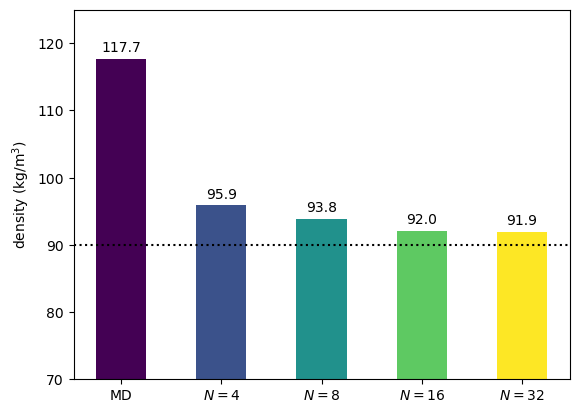

In [19]:
cap.show()

- At 33 K and 50 MPa the experimental density is around 90 kg/m<sup>3</sup>
- classical simulation yields too large density
- PIMD results converge close to the experimental result